<a href="https://colab.research.google.com/github/Habibahalya/Deep-learning-lanjut/blob/main/Tugas_3_VAE_Habibah_Alya_Deep_Learning_Lanjut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -------------------------------
# Tugas 1: Bangun VAE untuk Fashion-MNIST
# -------------------------------

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load dan Preproses Data
# -------------------------------
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

# Konversi ke float32 dan normalisasi ke [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Tambahkan padding menjadi 32x32
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

# Tambahkan channel grayscale (32, 32, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Data shape:", x_train.shape, x_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Data shape: (60000, 32, 32, 1) (10000, 32, 32, 1)


In [2]:
# -------------------------------
# 2. Bangun Encoder
# -------------------------------
latent_dim = 2

encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
shape_before_flattening = x.shape[1:]  # simpan shape untuk decoder
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling layer dengan reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# -------------------------------
# 3. Bangun Decoder
# -------------------------------
decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)
decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# -------------------------------
# 4. Bangun VAE dengan Custom Training Loop
# -------------------------------
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

# Instansiasi dan kompilasi VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam())

In [6]:
# -------------------------------
# 5. Latih Model
# -------------------------------
# Re-compile VAE with a dummy loss as the original compile was missing it
# Correcting the loss argument to match the multiple outputs of VAE.call() for validation.
vae.compile(optimizer=optimizers.Adam(), loss=[None, None, tf.keras.losses.MeanSquaredError()])
history = vae.fit(x_train, epochs=5, batch_size=128, validation_data=(x_test, x_test))



Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 201s 423ms/step - kl_loss: 4.4658 - reconstruction_loss: 394.8132 - total_loss: 399.2790 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 196s 418ms/step - kl_loss: 5.9963 - reconstruction_loss: 265.0379 - total_loss: 271.0342 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 196s 419ms/step - kl_loss: 6.0391 - reconstruction_loss: 260.6003 - total_loss: 266.6394 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 211s 438ms/step - kl_loss: 6.0512 - reconstruction_loss: 258.5315 - total_loss: 264.5828 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 205s 437ms/step - kl_loss: 6.1449 - reconstruction_loss: 257.6898 - total_los

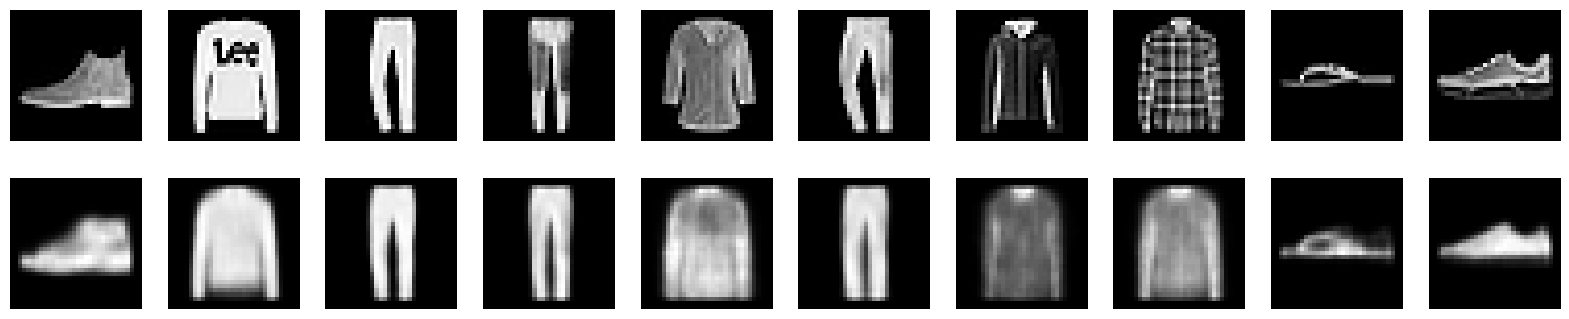

In [7]:
# -------------------------------
# 6. Visualisasi Rekonstruksi
# -------------------------------
def plot_reconstructions(model, data, n=10):
    _, _, reconstructions = model(data[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Asli
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        plt.axis("off")
        # Rekonstruksi
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].numpy().squeeze(), cmap="gray") # Fixed line
        plt.axis("off")
    plt.show()

plot_reconstructions(vae, x_test)

# -------------------------------
# 7. Simpan Model (opsional)
# -------------------------------
encoder.save("vae_fashion_encoder.h5")
decoder.save("vae_fashion_decoder.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


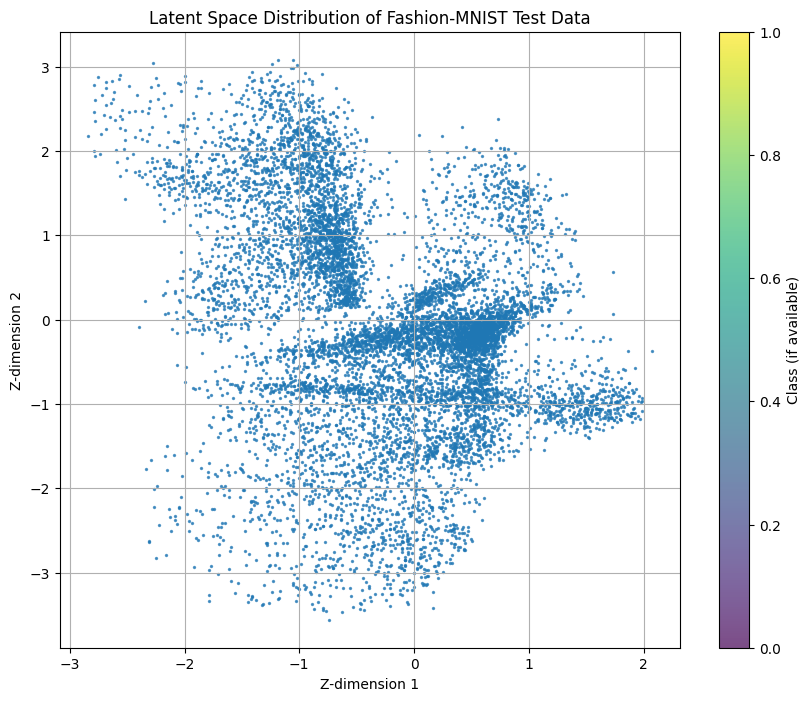

In [11]:
import matplotlib.pyplot as plt

# Asumsi z_means sudah dihitung dan tersedia dari encoder(x_test)
# Jika belum, uncomment baris berikut:
z_mean, _, _ = vae.encoder.predict(x_test)

plt.figure(figsize=(10, 8))
plt.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data")
plt.colorbar(label="Class (if available)") # Label ini akan tetap muncul, namun tidak ada warna berdasarkan kelas karena tidak ada label kelas yang dimuat.
plt.grid(True)
plt.show()

In [12]:
(_, y_train), (_, y_test) = keras.datasets.fashion_mnist.load_data()
print("y_test successfully loaded with shape:", y_test.shape)
print("First 10 y_test labels:", y_test[:10])

y_test successfully loaded with shape: (10000,)
First 10 y_test labels: [9 2 1 1 6 1 4 6 5 7]


Generate Latent Space Means for Test Data

In [14]:
print("Shape of z_mean:", z_mean.shape)
print("First 5 elements of z_mean:\n", z_mean[:5])

Shape of z_mean: (10000, 2)
First 5 elements of z_mean:
 [[-1.0755305   1.1237222 ]
 [ 0.637817   -0.09830862]
 [ 0.37871954 -2.73249   ]
 [-0.5373108  -2.3791287 ]
 [ 0.01381193 -0.04220822]]


Visualize Latent Space Distribution by Class

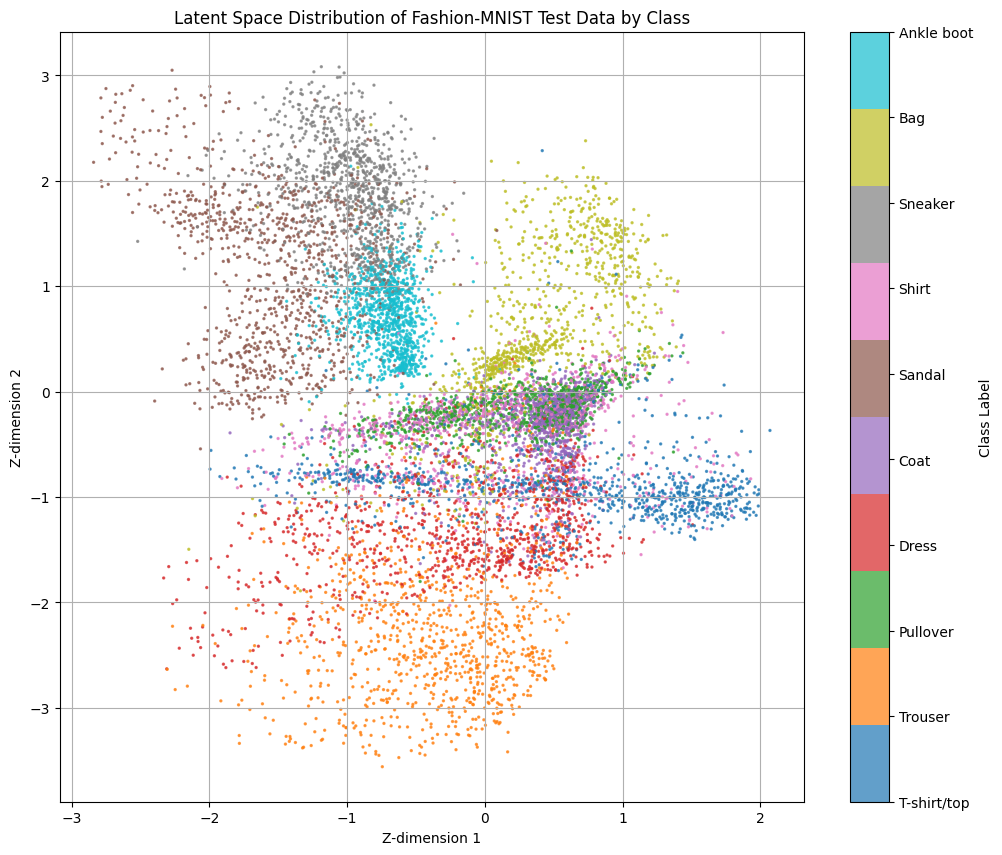

In [16]:
fashion_mnist_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap="tab10", alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data by Class")
cbar = plt.colorbar(scatter)
cbar.set_label("Class Label")
cbar.set_ticks(range(10))
cbar.set_ticklabels(fashion_mnist_labels)
plt.grid(True)
plt.show()

Latent space arithmetic


--- 8. Latent Space Arithmetic (VAE) ---
Vektor Rata-rata 'Ankle boot' (Label 9): [-0.70864093  0.70999706]
Vektor Rata-rata 'Sneaker' (Label 7): [-0.9867606  1.8554801]
Vektor Rata-rata 'Sandal' (Label 5): [-1.5286019  1.1290193]
Vektor Rata-rata 'Trouser' (Label 1): [-0.37053227 -2.2474666 ]

Vector Hasil 1 (Ankle boot - Sandal + Sneaker): [-0.16679966  1.4364579 ]
Vector Hasil 2 (Sandal - Ankle boot + Trouser): [-1.1904932 -1.8284444]


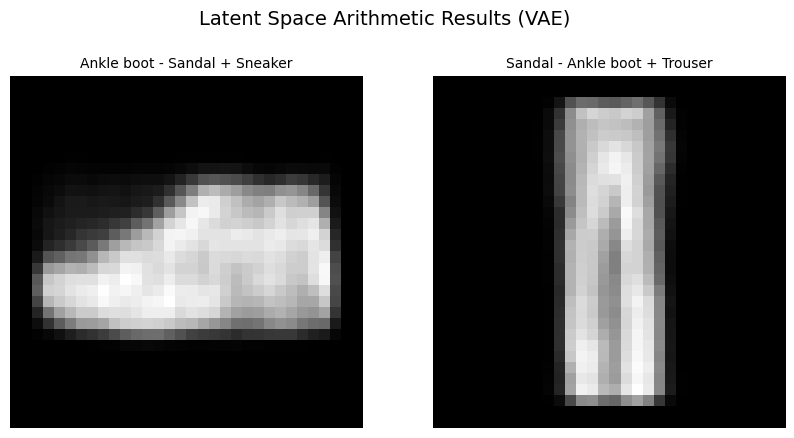

In [17]:
# Pastikan vae, encoder, decoder, x_test, dan y_test sudah terdefinisi.

print("\n--- 8. Latent Space Arithmetic (VAE) ---")

def get_latent_mean(class_label):
    class_indices = np.where(y_test == class_label)[0]
    class_images = x_test[class_indices]

    z_mean_list, _, _ = vae.encoder.predict(class_images, verbose=0)

    return np.mean(z_mean_list, axis=0)

# 9: Ankle boot, 7: Sneaker, 5: Sandal, 1: Trouser
ankle_boot_mean = get_latent_mean(9)
sneaker_mean = get_latent_mean(7)
sandal_mean = get_latent_mean(5)
trouser_mean = get_latent_mean(1)

print(f"Vektor Rata-rata 'Ankle boot' (Label 9): {ankle_boot_mean}")
print(f"Vektor Rata-rata 'Sneaker' (Label 7): {sneaker_mean}")
print(f"Vektor Rata-rata 'Sandal' (Label 5): {sandal_mean}")
print(f"Vektor Rata-rata 'Trouser' (Label 1): {trouser_mean}")


# Aritmatika 1: Ankle boot - Sandal + Sneaker
latent_vector_1 = ankle_boot_mean - sandal_mean + sneaker_mean
print(f"\nVector Hasil 1 (Ankle boot - Sandal + Sneaker): {latent_vector_1}")

# Aritmatika 2: Sandal - Ankle boot + Trouser
latent_vector_2 = sandal_mean - ankle_boot_mean + trouser_mean
print(f"Vector Hasil 2 (Sandal - Ankle boot + Trouser): {latent_vector_2}")


# Rekonstruksi Hasil Aritmatika
latent_vectors = np.array([
    latent_vector_1,
    latent_vector_2,
])

latent_vectors = np.expand_dims(latent_vectors, axis=0) if latent_vectors.ndim == 1 else latent_vectors

reconstructions = decoder.predict(latent_vectors, verbose=0)

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
titles = [
    "Ankle boot - Sandal + Sneaker",
    "Sandal - Ankle boot + Trouser"
]

for i, ax in enumerate(axes):
    ax.imshow(reconstructions[i].squeeze(), cmap="gray")
    ax.set_title(titles[i], fontsize=10)
    ax.axis("off")

plt.suptitle("Latent Space Arithmetic Results (VAE)", fontsize=14)
plt.show()


--- 9. Membangun dan Melatih Autoencoder Standar ---
Memulai pelatihan Autoencoder Standar (5 epochs)...
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 200s 419ms/step - loss: 0.2805 - val_loss: 0.2565
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 206s 429ms/step - loss: 0.2543 - val_loss: 0.2535
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 207s 441ms/step - loss: 0.2511 - val_loss: 0.2513
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 205s 437ms/step - loss: 0.2493 - val_loss: 0.2500
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 435ms/step - loss: 0.2481 - val_loss: 0.2492
Pelatihan AE selesai.


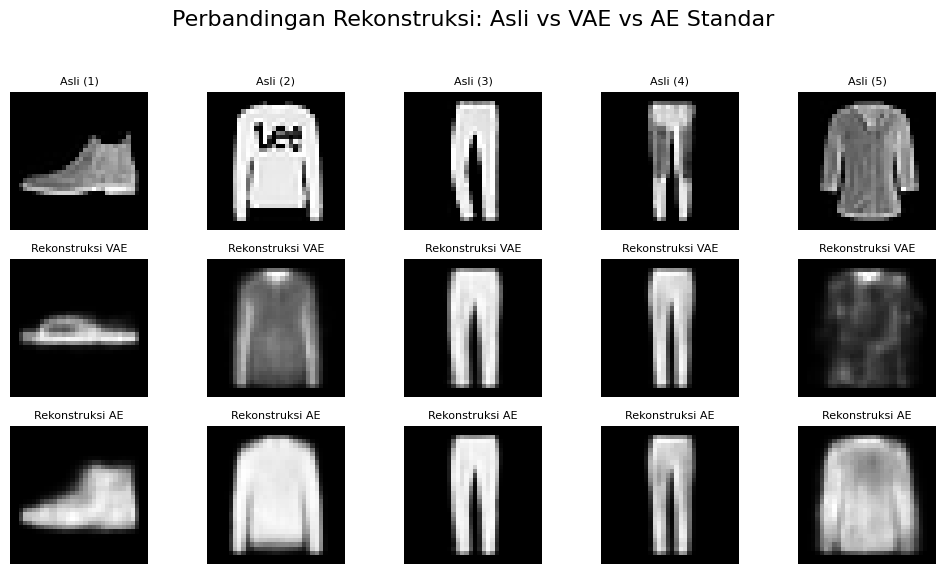

In [18]:
# Pastikan vae, decoder, x_train, x_test, dan latent_dim sudah terdefinisi.

print("\n--- 9. Membangun dan Melatih Autoencoder Standar ---")

# --- 9.1 Bangun Encoder dan AE Standar ---
# Encoder AE: Mirip VAE, tapi outputnya deterministik (hanya z_ae)
ae_encoder_input = layers.Input(shape=(32, 32, 1), name="ae_encoder_input")
ae_x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(ae_encoder_input)
ae_x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(ae_x)
ae_x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(ae_x)
ae_x = layers.Flatten()(ae_x)
z_ae = layers.Dense(latent_dim, name="z_ae")(ae_x) # Vektor Laten Deterministik

# Model AE menggunakan decoder yang SAMA dengan VAE
# Penting: Saat mendefinisikan AE, kita menggunakan decoder(z_ae)
ae = models.Model(ae_encoder_input, decoder(z_ae), name="Autoencoder")

# --- 9.2 Kompilasi dan Latih AE ---
ae.compile(optimizer='adam', loss=losses.BinaryCrossentropy())

print("Memulai pelatihan Autoencoder Standar (5 epochs)...")
ae.fit(x_train, x_train, epochs=5, batch_size=128, shuffle=True, validation_data=(x_test, x_test))
print("Pelatihan AE selesai.")


# --- 9.3 Visualisasi Perbandingan Rekonstruksi ---

def plot_comparison_reconstructions(original_data, vae_model, ae_model, n=5):
    # 1. Dapatkan Rekonstruksi VAE (Output ketiga VAE adalah rekonstruksi)
    _, _, vae_reconstructions = vae_model(original_data[:n])
    vae_reconstructions = vae_reconstructions.numpy()

    # 2. Dapatkan Rekonstruksi AE (Output AE adalah rekonstruksi)
    ae_reconstructions = ae_model.predict(original_data[:n], verbose=0)

    fig, axes = plt.subplots(3, n, figsize=(2 * n, 6))

    plt.suptitle("Perbandingan Rekonstruksi: Asli vs VAE vs AE Standar", fontsize=16)

    for i in range(n):
        # Baris 1: Asli
        axes[0, i].imshow(original_data[i].squeeze(), cmap="gray")
        axes[0, i].set_title(f"Asli ({i+1})", fontsize=8)
        axes[0, i].axis("off")

        # Baris 2: VAE
        axes[1, i].imshow(vae_reconstructions[i].squeeze(), cmap="gray")
        axes[1, i].set_title(f"Rekonstruksi VAE", fontsize=8)
        axes[1, i].axis("off")

        # Baris 3: AE Standar
        axes[2, i].imshow(ae_reconstructions[i].squeeze(), cmap="gray")
        axes[2, i].set_title(f"Rekonstruksi AE", fontsize=8)
        axes[2, i].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Tampilkan perbandingan menggunakan 5 gambar pertama dari data uji
plot_comparison_reconstructions(x_test, vae, ae, n=5)


# -------------------------------
# 10. Simpan Model (opsional)
# -------------------------------
# Hapus tanda komentar (#) jika ingin menyimpan model setelah pelatihan.
# encoder.save("vae_fashion_encoder.h5")
# decoder.save("vae_fashion_decoder.h5")
# ae.save("standard_ae.h5")